<a href="https://colab.research.google.com/github/virendra-haratlia/OpenCV/blob/main/11_objectTracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Tracking
**Satya Mallick, LearnOpenCV.com**

- What is tracking?
- Tracking in computer vison.
- Motion model and appearnace model.
- OpenCV API Tracker Class.

# Goal

 Given the initial location of an object, track location in subsequent frames

![Object Tracking](https://learnopencv.com/wp-content/uploads/2023/03/opencv_bootcamp_NB11_race_car_tracking.png)

In [ ]:
!pip uninstall numpy -y
!pip install numpy==1.26.4

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires opencv-python>=3.4.8.29, which is not installed.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


In [ ]:
!pip uninstall opencv-python -y
!pip install opencv-contrib-python==4.9.0.80

  Using cached opencv_contrib_python-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_contrib_python-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (68.3 MB)


In [ ]:
# Import modules

# import urllib

import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

from IPython.display import HTML
from matplotlib.animation import FuncAnimation

from IPython.display import YouTubeVideo, display, HTML
from base64 import b64encode

%matplotlib inline

##  <font style="color:black">Download Assets</font>

In [ ]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assests....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

In [ ]:
URL = r"https://www.dropbox.com/s/ld535c8e0vueq6x/opencv_bootcamp_assets_NB11.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), "opencv_bootcamp_assets_NB11.zip")

# Download if assest ZIP does not exists.
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)

# Tracker Class in OpenCV

1. BOOSTING
2. MIL
3. KCF
4. CRST
5. TLD
 * Tends to recover from occulusions
6. MEDIANFLOW
 * Good for predictable slow motion
7. GOTURN
 * Deep Learning based
 * Most Accurate
8. MOSSE
 * Fastest

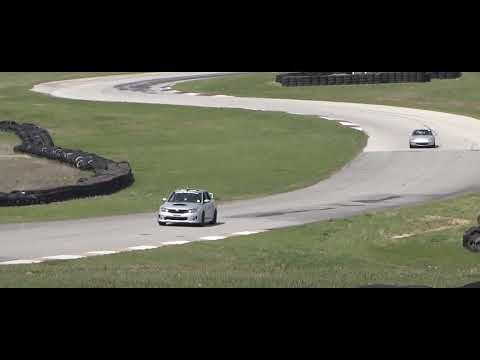

In [ ]:
video = YouTubeVideo("XkJCvtCRdVM", width=1024, height=640)
display(video)

In [ ]:
video_input_file_name = "race_car.mp4"


def drawRectangle(frame, bbox):
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(frame, p1, p2, (255, 0, 0), 2, 1)


def displayRectangle(frame, bbox):
    plt.figure(figsize=(20, 10))
    frameCopy = frame.copy()
    drawRectangle(frameCopy, bbox)
    frameCopy = cv2.cvtColor(frameCopy, cv2.COLOR_RGB2BGR)
    plt.imshow(frameCopy)
    plt.axis("off")


def drawText(frame, txt, location, color=(50, 170, 50)):
    cv2.putText(frame, txt, location, cv2.FONT_HERSHEY_SIMPLEX, 1, color, 3)

# GOTURN Tracker

![](https://learnopencv.com/wp-content/uploads/2023/03/opencv_bootcamp_NB11_goturn.jpg)

# Create the Tracker instance

In [ ]:
# Set up tracker
tracker_types = [
    "BOOSTING",
    "MIL",
    "KCF",
    "CSRT",
    "TLD",
    "MEDIANFLOW",
    "GOTURN",
    "MOSSE",
]

# Change the index to change the tracker type
tracker_type = tracker_types[3]

if tracker_type == 'BOOSTING':
    tracker = cv2.legacy.TrackerBoosting_create()
elif tracker_type == 'MIL':
    tracker = cv2.TrackerMIL_create()
elif tracker_type == 'KCF':
    tracker = cv2.TrackerKCF_create()
elif tracker_type == 'TLD':
    tracker = cv2.legacy.TrackerTLD_create()
elif tracker_type == 'MEDIANFLOW':
    tracker = cv2.legacy.TrackerMedianFlow_create()
elif tracker_type == 'GOTURN':
    tracker = cv2.TrackerGOTURN_create()
elif tracker_type == "CSRT":
    tracker = cv2.TrackerCSRT_create()
elif tracker_type == "MOSSE":
    tracker = cv2.legacy.TrackerMOSSE_create()
else:
    tracker = None

# Read input video & Setup output Video

In [ ]:
# Read video
video = cv2.VideoCapture(video_input_file_name)
ok, frame = video.read()

# Exit if video not opened
if not video.isOpened():
    print("Could not open video")
    sys.exit()
else:
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

video_output_file_name = "race_car-" + tracker_type + ".mp4"
video_out = cv2.VideoWriter(video_output_file_name, cv2.VideoWriter_fourcc(*"XVID"), 10, (width, height))

video_output_file_name

'race_car-CSRT.mp4'

# Define Bounding Box

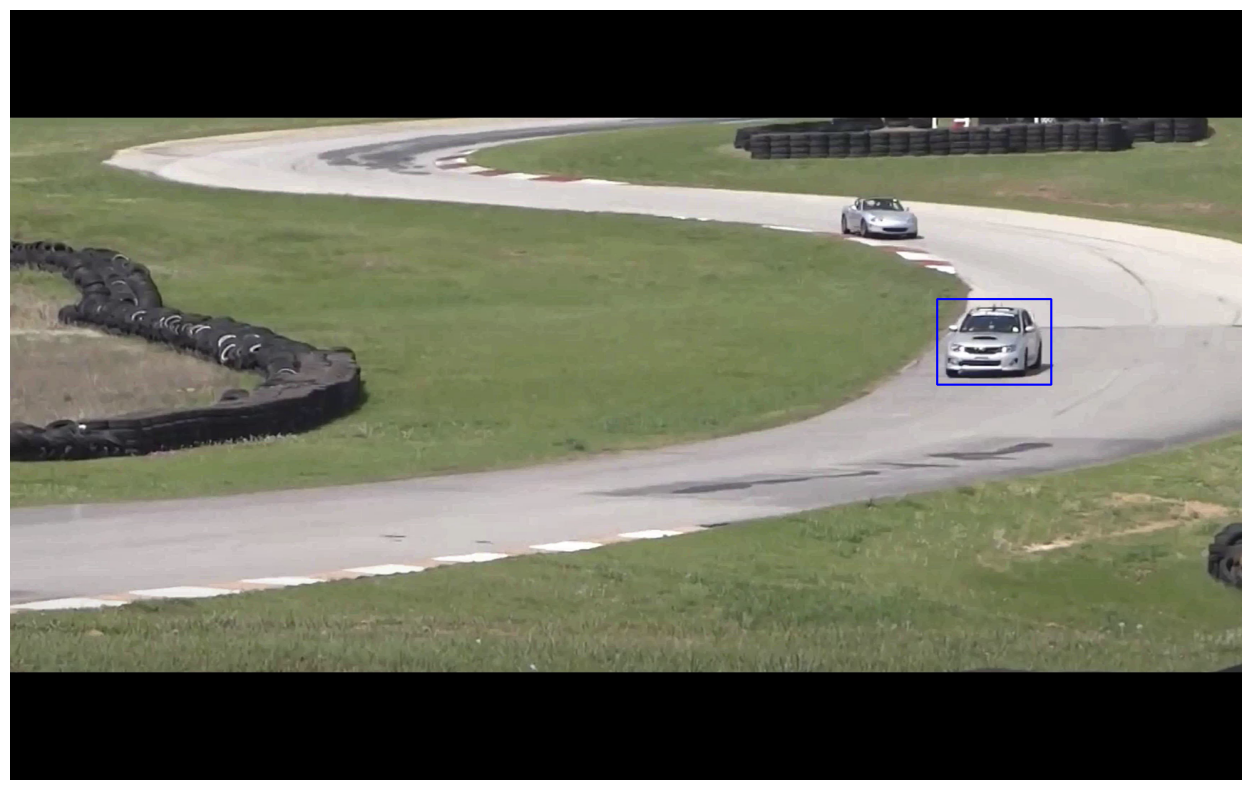

In [ ]:
# Define a bounding box
bbox = (1300, 405, 160, 120)
# bbox = cv2.selectROI(frame, False)
# print(bbox)
displayRectangle(frame, bbox)

# Intilialize Tracker

1. One frame
2. A bounding box


In [ ]:
# Initialize tracker with first frame and bounding box

ok = tracker.init(frame, bbox)

# Read frame and Track Object

In [ ]:
while True:
    ok, frame = video.read()

    if not ok:
        break

    # Start timer
    timer = cv2.getTickCount()

    # Update tracker
    ok, bbox = tracker.update(frame)

    # Calculate Frames per second (FPS)
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)

    # Draw bounding box
    if ok:
        drawRectangle(frame, bbox)
    else:
        drawText(frame, "Tracking failure detected", (80, 140), (0, 0, 255))

    # Display Info
    drawText(frame, tracker_type + " Tracker", (80, 60))
    drawText(frame, "FPS : " + str(int(fps)), (80, 100))

    # Write frame to video
    video_out.write(frame)

video.release()
video_out.release()

In [ ]:
# Installing ffmpeg
!apt-get -qq install ffmpeg

# Change video encoding of mp4 file from XVID to h264
!ffmpeg -y -i {video_output_file_name} -c:v libx264 $"race_car_track_x264.mp4"  -hide_banner -loglevel error

Render MP4 Video

In [ ]:
mp4 = open("/content/race_car_track_x264.mp4", "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML(f"""<video width=1024 controls><source src="{data_url}" type="video/mp4"></video>""")

The expected video rendered in the above cell should be the same as the following.

In [ ]:
# Tracker: KCF
video = YouTubeVideo("pk3tmdRX4ww", width=1024, height=640)
display(video)

In [ ]:
# Tracker: CSRT
video = YouTubeVideo("6gGDf-7ypBE", width=1024, height=640)
display(video)

In [ ]:
# Tracker: GOTURN
video = YouTubeVideo("0bnWxc4zMvY", width=1024, height=640)
display(video)

# Thank You!